In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import os 
import scipy
import tqdm
import time
os.sys.path.append('../../LHAASO_PSF/PSFConv/')
import PSF

def targetconv(src,target_sig=0.1,psfradius=1,returnPSF = False):
    '''
    Args: 
    1. src, sky map containing the source, without PSF
    
    Returns: 
    1. the sky map after convolution with PSF
    '''
    def singlegauss(x,sig1,amp1):
        return amp1 * 1/(np.sqrt(2 * np.pi)*sig1) * np.exp(-(x)**2/2/sig1**2)

    
    radius = psfradius # 2度以外就视为psf没有贡献了
    x = np.arange(src.shape[0])/10
    y = np.arange(src.shape[1])/10
    lenx = x.shape[0]
    leny = y.shape[0]
    midx = np.median(x)
    midy = np.median(y)
    ixl = np.argmin(np.abs(x-midx+radius)) #index_x_left, 卷积核对应x的最小坐标
    ixr = np.argmin(np.abs(x-midx-radius))
    iyl = np.argmin(np.abs(y-midy+radius))
    iyr = np.argmin(np.abs(y-midy-radius))
    #那么定义卷积核
    xx,yy = np.meshgrid(x,y)
    #卷积核为包含半径为radius的区域
    r0 = np.sqrt((xx-midx)**2+(yy-midy)**2) #
    kernel = singlegauss(r0[iyl:iyr,ixl:ixr],target_sig,amp1 = 1)
    #kernel = gauss1d(r0[iyl:iyr,ixl:ixr],*bestfit) 
    kernel = kernel/kernel.sum()#归一化

    summap = scipy.signal.convolve2d(src,kernel,mode='same',boundary = 'fill',fillvalue=0)
    if returnPSF: 
        psfx = np.linspace(0,psfradius,101)
        psfy = singlegauss(psfx,target_sig,amp1 = 1)
        norm = 2 * np.pi * numint(psfx,psfx * psfy)
        return summap,(psfx,psfy/norm)
    return summap

psfconv = PSF.lhaaso_psf(4)

In [2]:
if os.path.exists('./targconvlist'):
    print('file list exists.')
else:
    os.system('ls ./no_fps_data/*.fits > ./targconvlist')
    #os.system('ls ./Gaussion_0.2_data/*.fits > ./psfconvlist')
#os.system('ls ./no_fps_data/*.fits > ./targconvlist')
origdata = []
blurdata = []
convlist = np.loadtxt('./targconvlist',dtype=object)
#psfconvlist = np.loadtxt('./psfconvlist',dtype=object)
print('start loading')
def proc(i):
    np.random.seed(int((time.time()-int(time.time()))*1e6))
    
    file = convlist[i]
    with fits.open(file) as f:
        data = f[0].data
    cpx = int(data.shape[0]/2)
    cpy = int(data.shape[1]/2)
    hp  = 32
    x = np.arange(2*hp)/10
    
    blur= psfconv(data,x,x)[cpx-hp:cpx+hp,cpy-hp:cpy+hp]
    orig=data[cpx-hp:cpx+hp,cpy-hp:cpy+hp]
    if np.mod(i,500) == 0:
        print(i)
    return (blur,orig)

from multiprocessing import Pool
with Pool(12) as pool:
    res = pool.map(proc,np.arange(len(convlist)))


    

'''for i in tqdm.trange(convlist.shape[0]):
    file = convlist[i]
    with fits.open(file) as f:
        data = f[0].data
    cpx = int(data.shape[0]/2)
    cpy = int(data.shape[1]/2)
    x = np.arange(2*hp)/10
    hp  = 32
    blurdata.append(psfconv(data,x,x)[cpx-hp:cpx+hp,cpy-hp:cpy+hp])
    origdata.append(data[cpx-hp:cpx+hp,cpy-hp:cpy+hp])'''
    #del(data)
print('finish load')


file list exists.
start loading
0
1000
500
2000
1500
2500
3500
3000
4000
4500
finish load


In [3]:
for i in range(len(res)):
    origdata.append(res[i][1])
    blurdata.append(res[i][0])
dataset = np.stack((np.array(origdata),np.array(blurdata)),axis = 1)
np.save('../../SimulatedData/GaussianSRC_tx_new.npy',dataset)

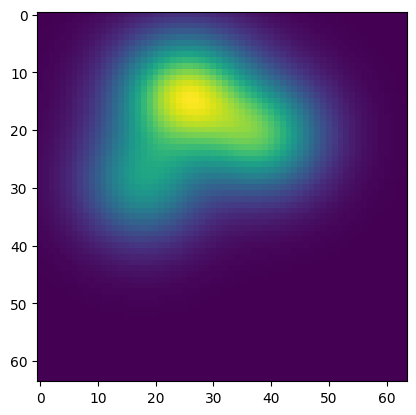

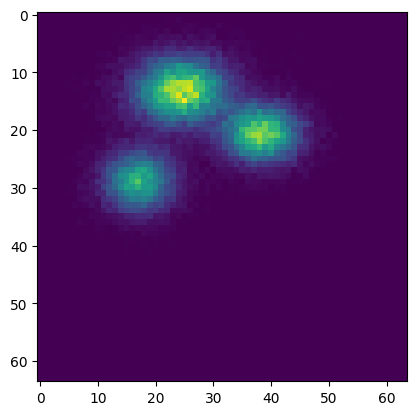

In [4]:
a = 12
plt.imshow(res[a][0])
plt.figure()
plt.imshow(res[a][1])
#plt.imshow(np.log10(res[a][1]))



In [12]:
nprocimg = 2000
def gauss2d(r,sig):
    return np.exp(-r**2/2/sig**2)
def pointproc(i):
    np.random.seed(int((time.time()-int(time.time()))*1e6))
    npointsrc = np.random.randint(1,3)
    data = np.zeros((110,110))
    x = np.arange(110)/10
    y = np.arange(110)/10
    xx,yy =np.meshgrid(x,y)
    cpx = int(x.shape[0]/2)
    cpy = int(y.shape[0]/2)
    hp=32
    for idx in range(npointsrc):
        ncts = 10**np.random.normal(loc=4,scale=0.2)
        x_src = np.random.uniform(x[cpx-int(hp*0.8)],x[cpx+int(hp*0.8)])
        y_src = np.random.uniform(y[cpx-int(hp*0.8)],y[cpx+int(hp*0.8)])
        r_tmp = np.sqrt((xx-x_src)**2+(yy-y_src)**2)
        intensity_tmp =  gauss2d(r_tmp,10**np.random.normal(loc = np.log10(0.07),scale=0.1))
        intensity_tmp = intensity_tmp/intensity_tmp.sum()*ncts
        data += intensity_tmp
    blur= psfconv(data,x,x)[cpx-hp:cpx+hp,cpy-hp:cpy+hp]
    orig=data[cpx-hp:cpx+hp,cpy-hp:cpy+hp]
    return (blur,orig)

with Pool(12) as pool:
    res = pool.map(pointproc,np.arange(2000))
origdata = []
blurdata = []
for i in range(len(res)):
    origdata.append(res[i][1])
    blurdata.append(res[i][0])
dataset = np.stack((np.array(origdata),np.array(blurdata)),axis = 1)
np.save('../../SimulatedData/PointSRC.npy',dataset)

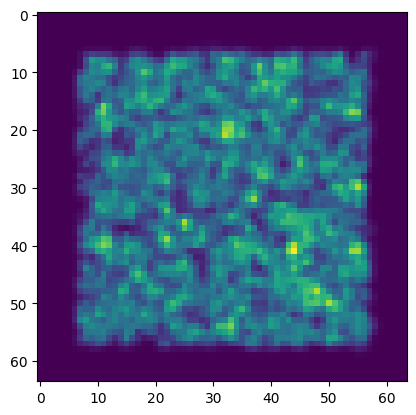

In [6]:
a = 1200
restmp = res[0][0]
for a in range(1,2000):
    restmp += res[a][1]
plt.imshow(res[a][1])